# Deep Q-Learning (DQN)
In this tutorial, we will implement DQN in the Mountain Car environment that you should know...
**Now we are not in table RL anymore, we deal with continuous spaces !**

## Imports and Utils
Don't pay attention to this part

In [1]:
import math, random, os

import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [18]:
import imageio
from PIL import Image as PILImage
from IPython.display import Image
# Define the directory to save the GIF
gif_dir = '/content/drive/MyDrive/gifs'  # Replace with your desired directory
os.makedirs(gif_dir, exist_ok=True)

# Function to run an episode and save as GIF
def run_and_save_gif(model, env, episode_length=200):
    images = []
    state = env.reset()
    total_reward = 0

    for step in range(episode_length):
        epsilon = 0.01  # Set a low epsilon for demonstration
        action = model.act(state, epsilon)

        if isinstance(action, torch.Tensor):
            action = action.item()
        next_state, reward, done, _ = env.step(action)
        total_reward += reward

        # Render the environment and append the image as a NumPy array
        img = env.render(mode='rgb_array')
        images.append(PILImage.fromarray(img))  # Explicitly use PILImage
        state = next_state
        if done:
            break

    gif_filename = os.path.join(gif_dir, f"episode_{len(os.listdir(gif_dir))}.gif")
    imageio.mimsave(gif_filename, images, fps=30)  # Adjust fps as needed
    print(f"GIF saved to: {gif_filename}")
    print(f"Total reward: {total_reward}")

    return gif_filename

In [4]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda


## Mountain Car Environment

A car is on a one-dimensional track, positioned between two "mountains".<br>
The goal is to drive up the mountain on the right; however, the car's engine is not strong enough to scale the mountain in a single pass.<br>
Therefore, the only way to succeed is to drive back and forth to build up momentum.

<img align="Left" src="https://www.gymlibrary.dev/_images/mountain_car.gif" width = 40% >

In [5]:
env_id = "MountainCar-v0"
env = gym.make(env_id)


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


**-> print State and action spaces**

> Ajouter une citation



In [6]:
### YOUR CODE HERE
# Afficher les espaces d'états et d'actions
print("State space (observation space):", env.observation_space)
print("Action space:", env.action_space)

# Afficher les détails des bornes des espaces d'état si disponibles
print("\nState space high bounds:", env.observation_space.high)
print("State space low bounds:", env.observation_space.low)

# Afficher le nombre d'actions disponibles
print("\nNumber of actions:", env.action_space.n)

###

State space (observation space): Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Action space: Discrete(3)

State space high bounds: [0.6  0.07]
State space low bounds: [-1.2  -0.07]

Number of actions: 3


# Implementing DQN

## Creating the Replay Buffer

DQNs tend to “forget” certain $(s,a)=r$ situations it encountered in the past (kinda like catastrophic forgetting).

Whole __experience replay__ idead is tp maintain a buffer of the old experiences and train it again on them.

In [12]:
from collections import deque

class ReplayBuffer:
    def __init__(self, capacity, device=torch.device("cpu")):
        self.buffer = deque(maxlen=capacity)
        self.device = device

    def push(self, state, action, reward, next_state, done):
        state      = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)

        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return np.concatenate(state), action, reward, np.concatenate(next_state), done

    def __len__(self):
        return len(self.buffer)

## Epsilon greedy exploration

Greedy and Epsilon Greedy exploration methods are fairly easy to understand and to implement, but they suffer from major setback which is they have sub-optimal regret. As a matter of fact the regret of both Greedy and Epsilon Greedy grows linearly by the time.

This is easy to intuitively understand, as the Greedy will lock on one action that happened to have good results at one point of time but it is not in reality the optimal action. So Greedy will keep exploiting this action while ignoring the others which might be better. It Exploits too much.

The Epsilon Greedy on the other hand, explores too much because even when one action seem to be the optimal one, the methods keeps allocating a fixed percentage of the time for exploration.

Conversely the decaying Epsilon Greedy methods, tries to decrease the percentage dedicated for exploration as time goes by.<br>
Exploration probability is shown in the graph below.

In [13]:
epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 500

def epsilon_by_frame(frame_idx):
    return epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)

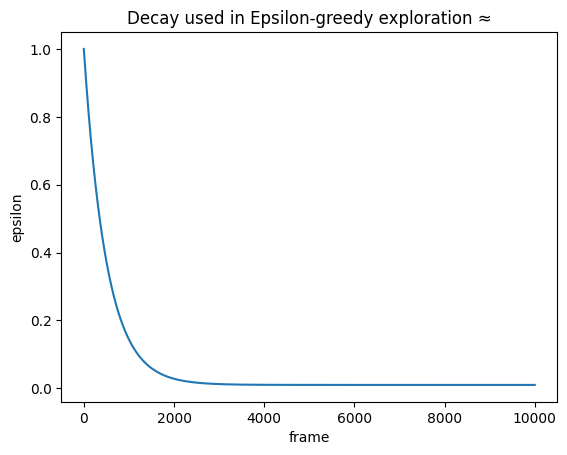

In [14]:
plt.title('Decay used in Epsilon-greedy exploration ≈')
plt.xlabel('frame')
plt.ylabel('epsilon')
plt.plot([epsilon_by_frame(i) for i in range(10000)])


## Deep Q-Network

Our DQN model is a feed forward neural network, trained with a variant of Q-learning. It was first applied to seven Atari 2600 games from the Arcade Learning Environment, with no adjustment of the architecture or learning algorithm.
In the Paper they write:
> "We instead use an architecture
in which there is a separate output unit for each possible action, and **only the state representation is
an input to the neural network**. The outputs correspond to the predicted Q-values of the individual
action for the input state. The main advantage of this type of architecture is the ability to compute
Q-values for all possible actions in a given state with only a single forward pass through the network."

For more info we suggest reading the original DeepMind paper https://arxiv.org/pdf/1312.5602

**-> Implement a NN with nn.Sequential that will be our Q network, use 3 Linear layers with 128 Neurons**, *be careful of the input / outputs  dimensions !*

**-> Complete the `act()` function to implement Eps-greedy policy**

In [15]:
class DQN(nn.Module):
    def __init__(self, num_inputs, num_actions):
        super().__init__()

        self.num_actions = num_actions

        ##################
        ###### YOUR CODE HERE
        # Réseau neuronal avec 3 couches linéaires
        self.layers = nn.Sequential(
            nn.Linear(num_inputs, 128),  # Entrée: num_inputs, Sortie: 128
            nn.ReLU(),                  # Fonction d'activation ReLU
            nn.Linear(128, 128),        # Entrée: 128, Sortie: 128
            nn.ReLU(),                  # Fonction d'activation ReLU
            nn.Linear(128, num_actions) # Entrée: 128, Sortie: num_actions (Q-valeurs pour chaque action)
        )
        ##################

    def forward(self, x):
        # Propagation avant
        return self.layers(x)

    def act(self, state, epsilon):
        """"
        Given a state, take an epsilon-greedy action
        Args:
          state: a state from the environment
          epsilon: the probability of choosing a random action
        Returns:
          action (int): the action to take
        """
        rand_float = random.random()  # Génère un nombre aléatoire entre 0 et 1

        ##################
        ###### YOUR CODE HERE

        if rand_float < epsilon:
            # Choisir une action aléatoire avec probabilité epsilon
            action = random.randint(0, self.num_actions - 1)
        else:
            # Calculer l'action qui maximise la Q-valeur
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)  # Ajouter une dimension pour le batch
            q_values = self.forward(state_tensor)  # Q-valeurs pour chaque action
            action = q_values.argmax(dim=1).item()  # Obtenir l'indice de l'action avec la plus grande Q-valeur
        ##################

        return action


## Training


### Instanciate The Model

In [16]:
model = DQN(env.observation_space.shape[0], env.action_space.n)
model = model.to(device)

optimizer = optim.Adam(model.parameters())
# Create Replay buffer for our model
replay_buffer = ReplayBuffer(capacity=1000)

We can visualize the behavior of our untrained model as follows

GIF saved to: /content/drive/MyDrive/gifs/episode_1.gif
Total reward: -200.0


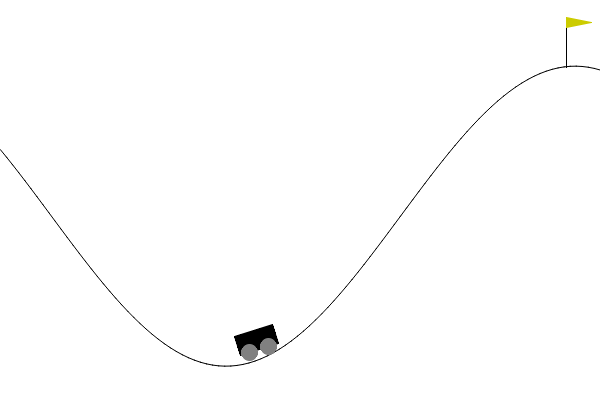

In [19]:
fileName = run_and_save_gif(model, env)
# Display the GIF using IPython.display.Image
Image(filename=fileName )

### Temporal Difference Loss
To Train our DQN, we will use an hybrid algorithm:

We optimize our parameters so that we obtain the best possible Q value. The Loss is computed as $$ \mathcal L = (\hat Q_t - \hat Q_{t+1})^2$$

**-> Compute the loss in the given function**

**-> Are we doing TD (Bootstrapping) or Monte Carlo ?**

In [20]:
def compute_td_loss(batch_size):
    """ Computes the Temporal Difference Loss and backpropagates the gradients
    """
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)

    state      = torch.FloatTensor(state).to(device)
    next_state = torch.FloatTensor(next_state).to(device)
    action     = torch.LongTensor(action).to(device)
    reward     = torch.FloatTensor(reward).to(device)
    done       = torch.FloatTensor(done).to(device)

    # Q-valeurs actuelles et suivantes
    q_values      = model(state)  # Q-valeurs pour chaque action
    next_q_values = model(next_state)  # Q-valeurs pour l'état suivant

    # Q-valeurs spécifiques à l'action prise
    q_value          = q_values.gather(1, action.unsqueeze(1)).squeeze(1)  # Q(s, a)
    next_q_value     = next_q_values.max(1)[0]  # max_a' Q(s', a')
    expected_q_value = reward + gamma * next_q_value * (1 - done)  # Valeur Q cible (Bellman)

    ##################
    ###### YOUR CODE HERE
    # Calcul de la perte : Erreur quadratique moyenne entre Q et Q attendu
    loss = nn.MSELoss()(q_value, expected_q_value.detach())
    ##################

    # Propagation arrière pour mettre à jour les poids
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss


In [22]:
def plot(frame_idx, rewards, losses, env):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.subplot(133)
    plt.title('environment')
    plt.imshow(env.render(mode='rgb_array'))

    plt.show()

### Training Loop
Now we have everything needed to train our DQN !

**-> Complete the training loop and train your DQN model with the given hyperparamters, Comment**

In [23]:
state = env.reset()

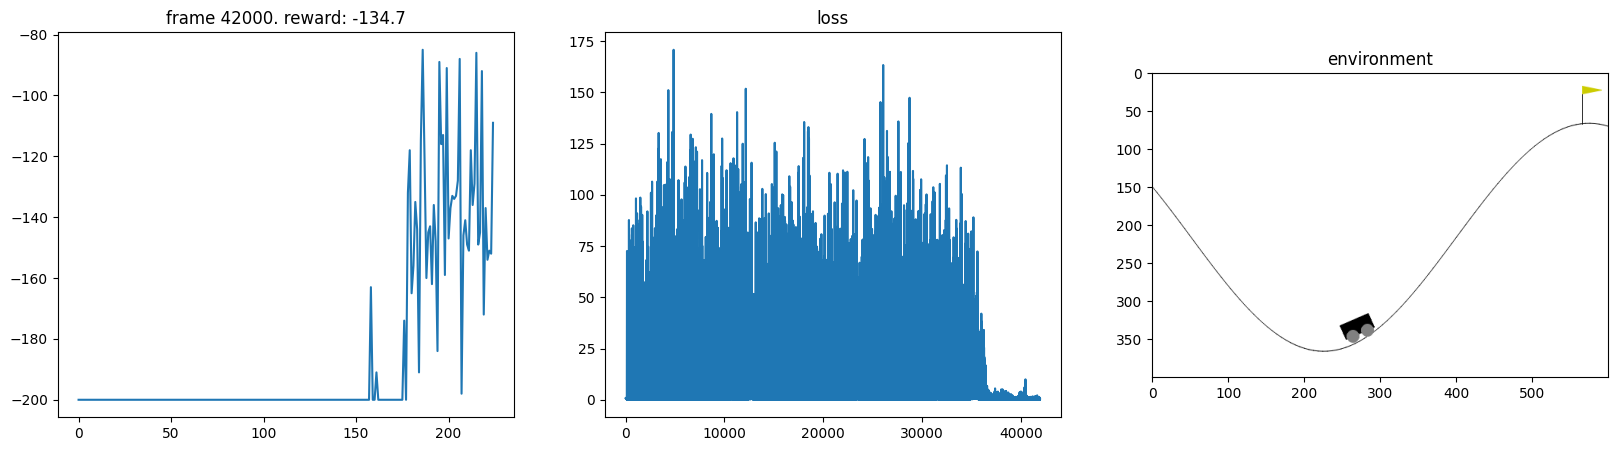

In [ ]:
do_training = True

if do_training:
    num_frames = 100000   # Nombre total d'itérations d'entraînement
    batch_size = 64       # Taille du lot pour la mise à jour du modèle
    gamma = 0.99          # Facteur de discount
    plot_every = 1000     # Fréquence de mise à jour des graphiques

    losses = []           # Liste pour suivre les pertes
    all_rewards = []      # Liste pour suivre les récompenses par épisode
    episode_reward = 0    # Récompense accumulée pour l'épisode en cours

    state = env.reset()   # Initialisation de l'état

    for frame_idx in range(1, num_frames + 1):
        # Utiliser la décroissance d'epsilon
        epsilon = epsilon_by_frame(frame_idx)

        # Prendre une action selon la politique epsilon-greedy
        action = model.act(state, epsilon)

        if isinstance(action, torch.Tensor):
            action = action.item()  # Convertir le tenseur en entier

        # Effectuer une étape dans l'environnement
        next_state, reward, done, _ = env.step(action)

        # Stocker la transition dans le buffer
        replay_buffer.push(state, action, reward, next_state, done)

        # Mettre à jour l'état et accumuler la récompense
        state = next_state
        episode_reward += reward

        # Si l'épisode est terminé, réinitialiser l'environnement
        if done:
            state = env.reset()
            all_rewards.append(episode_reward)
            episode_reward = 0

        # Effectuer une mise à jour si le buffer contient suffisamment d'exemples
        if len(replay_buffer) > batch_size:
            loss = compute_td_loss(batch_size)  # Calculer la perte
            losses.append(loss.data.item())     # Suivre la perte

        # Afficher les graphiques périodiquement
        if frame_idx % plot_every == 0:
            plot(frame_idx, all_rewards, losses, env)


## Visualizing Trained Policy

In [ ]:
fileName = run_and_save_gif(model, env)
# Display the GIF using IPython.display.Image
Image(filename=fileName )

# Next steps?,

Now you can
* Consider using larger DQN architectures.
* Try to train faster, with more/less exploration ? With different decay ?
* Play around with actual Atari environments https://gym.openai.com/envs/#atari.
* Explore more DQN tricks https://drive.google.com/file/d/0BxXI_RttTZAhVUhpbDhiSUFFNjg/view.